Tic Tac Toe
---
Two players against each other

<img style="float:left" src="board.png" alt="drawing" width="200"/>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [11]:
BOARD_ROWS = 3
BOARD_COLS = 3

In [12]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1
    
    # get unique hash of current board state
    def getHash(self):
        self.boardHash = str(self.board.reshape(BOARD_COLS*BOARD_ROWS))
        return self.boardHash
    
    def winner(self):
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS-i-1] for i in range(BOARD_COLS)])
        diag_sum = max(diag_sum1, diag_sum2)
        if diag_sum == 3:
            self.isEnd = True
            return 1
        if diag_sum == -3:
            self.isEnd = True
            return -1
        
        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None
    
    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions
    
    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1
    
    # only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)
    
    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1
   
    def play(self, rounds=100):
        for i in range(rounds):
            if i%1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)
                    
                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break
    
    # play with human
    def play2(self):
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            print('\n\nComputer Turn:')
            self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions)

                self.updateState(p2_action)
                print('Human Turn:')
                self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        print(self.p2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break

    def showBoard(self):
        # p1: x  p2: o
        # create figure instance
        fig1 = plt.figure(1)
        fig1.set_figheight(3)
        fig1.set_figwidth(3)

        rect = fig1.patch

        ax = fig1.add_subplot(1,1,1)

        ax.axhline(y=1, xmin=0, xmax=5, color='black')
        ax.axhline(y=0.33, xmin=0, xmax=5, color='black')
        ax.axhline(y=0.66, xmin=0, xmax=5, color='black')
        ax.axhline(y=0, xmin=0, xmax=5, color='black')
        ax.axvline(x=0, ymin=0, ymax=5, color='black')
        ax.axvline(x=1, ymin=0, ymax=5, color='black')
        ax.axvline(x=0.33, ymin=0, ymax=5, color='black')
        ax.axvline(x=0.66, ymin=0, ymax=5, color='black')
        ax.axis('off')

        #Adding text inside a rectangular box by using the keyword 'bbox'
        posx = [0.1,0.45,0.75]
        posy = [0.1,0.45,0.75][::-1]
        for i in range(0, BOARD_ROWS):
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    plt.text(posx[j], posy[i], 'x',fontsize = 25)
                if self.board[i, j] == -1:
                    plt.text(posx[j], posy[i], 'o',fontsize = 25)
        plt.show()


In [13]:
class Player:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []  # record all positions taken
        self.lr = 0.7
        self.exp_rate = exp_rate
        self.decay_gamma = 0.3
        self.states_value = {}  # state -> value
 
    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS*BOARD_ROWS))
        return boardHash
   
    def chooseAction(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                if value >= value_max:
                    value_max = value
                    action = p
        # print("{} takes action {}".format(self.name, action))
        return action
    
    # append a hash state
    def addState(self, state):
        self.states.append(state)
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr*(self.decay_gamma*reward - self.states_value[st])
            reward = self.states_value[st]
            
    def reset(self):
        self.states = []
        
    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file,'rb')
        self.states_value = pickle.load(fr)
        fr.close()

In [14]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name 
    
    def chooseAction(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action
    
    # append a hash state
    def addState(self, state):
        pass
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass
            
    def reset(self):
        pass

### Training

In [15]:
p1 = Player("p1")
p2 = Player("p2")

st = State(p1, p2)
print("training...")
st.play(1500)

training...
Rounds 0
Rounds 1000


In [16]:
p1.savePolicy()
p2.savePolicy()

In [17]:
p1.loadPolicy("policy_p1")

### Human vs Computer



Computer Turn:


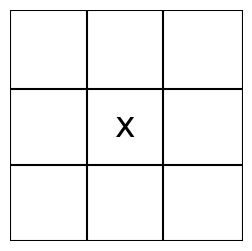

Human Turn:


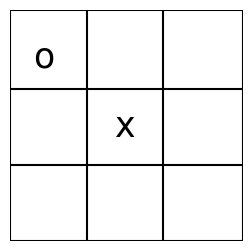



Computer Turn:


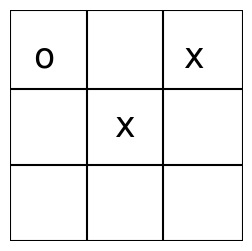

Human Turn:


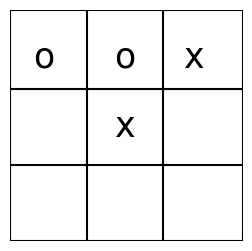



Computer Turn:


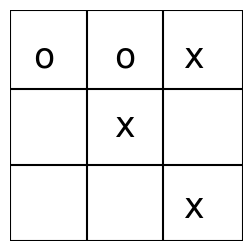

Human Turn:


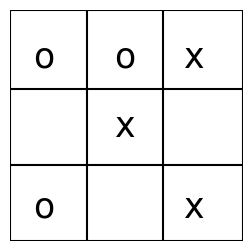



Computer Turn:


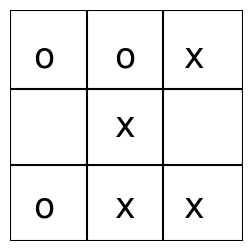

ValueError: invalid literal for int() with base 10: ''

In [18]:
p1 = Player("computer", exp_rate=0)
p1.loadPolicy("policy_p1")

p2 = HumanPlayer("human")

st = State(p1, p2)
st.play2()